In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-27 00:40:16.440185


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v3" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v3"]).reset_index(drop=True)

df_review:
source                      0
hotel_id                    0
hotel_name                  0
country                     0
group_name                  0
room_type                   0
stay_length                 0
stay_date                   0
review_score                0
review_score_category       0
sentiment                   0
review_date                 0
review_title                1
review                      0
review_cleaned_v1           0
review_cleaned_v2           0
review_cleaned_v3        1635
dtype: int64
Total rows in df_review: 39602 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.30  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,495,1573,2068
2023,1568,6068,7636
2024,322,1364,1686
Total,2385,9005,11390


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [02:44<21:52, 164.03s/it]

Topic #1:
0.385*"great" + 0.212*"friendly" + 0.182*"station" + 0.169*"breakfast" + 0.155*"helpful" + 0.141*"overall" + 0.138*"really" + 0.137*"singapore" + 0.133*"close" + 0.131*"food" + 0.129*"bathroom" + 0.128*"shower" + 0.125*"restaurant" + 0.121*"service" + 0.117*"comfortable" + 0.111*"pool" + 0.110*"facility" + 0.107*"quite" + 0.107*"price" + 0.106*"provide"

Topic #2:
-0.856*"great" + 0.184*"station" + 0.088*"shower" + 0.084*"quite" + 0.081*"bus" + 0.077*"towel" + 0.074*"bathroom" + 0.073*"toilet" + 0.069*"water" + 0.068*"use" + 0.064*"provide" + -0.060*"pool" + 0.060*"two" + 0.060*"really" + -0.059*"facility" + 0.057*"request" + 0.057*"next" + 0.056*"walk" + 0.055*"reception" + 0.054*"luggage"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [05:30<19:18, 165.55s/it]

Topic #1:
0.383*"great" + 0.212*"friendly" + 0.181*"station" + 0.170*"breakfast" + 0.155*"helpful" + 0.141*"overall" + 0.138*"really" + 0.138*"singapore" + 0.133*"close" + 0.131*"food" + 0.130*"bathroom" + 0.129*"shower" + 0.124*"restaurant" + 0.121*"service" + 0.117*"comfortable" + 0.111*"pool" + 0.111*"facility" + 0.108*"quite" + 0.108*"price" + 0.106*"provide"

Topic #2:
-0.861*"great" + 0.151*"station" + 0.095*"shower" + 0.090*"quite" + 0.081*"toilet" + 0.079*"bathroom" + 0.077*"towel" + 0.070*"bus" + 0.069*"water" + 0.067*"really" + 0.065*"provide" + 0.065*"use" + -0.064*"pool" + 0.059*"next" + 0.058*"two" + -0.056*"facility" + 0.055*"request" + 0.052*"walk" + 0.050*"reception" + 0.050*"many"

Topic #3:
-0.523*"station" + -0.294*"breakfast" + 0.204*"shower" + -0.203*"bus" + 0.173*"reception" + -0.170*"food" + -0.156*"close" + 0.142*"toilet" + -0.141*"restaurant" + 0.131*"bathroom" + -0.128*"singapore" + 0.127*"tell" + 0.125*"call" + 0.111*"really" + 0.108*"towel" + 0.106*"quite" +

 33%|███████████████████████████▋                                                       | 3/9 [08:28<17:06, 171.06s/it]

Topic #1:
0.382*"great" + 0.213*"friendly" + 0.181*"station" + 0.170*"breakfast" + 0.155*"helpful" + 0.141*"overall" + 0.138*"really" + 0.138*"singapore" + 0.133*"close" + 0.131*"food" + 0.130*"bathroom" + 0.129*"shower" + 0.124*"restaurant" + 0.121*"service" + 0.117*"comfortable" + 0.111*"pool" + 0.110*"facility" + 0.108*"quite" + 0.108*"price" + 0.106*"provide"

Topic #2:
-0.864*"great" + 0.123*"station" + 0.108*"shower" + 0.096*"quite" + 0.092*"toilet" + 0.088*"bathroom" + 0.075*"water" + 0.073*"really" + 0.073*"towel" + 0.066*"provide" + 0.065*"use" + -0.061*"pool" + 0.059*"next" + 0.058*"bus" + -0.055*"facility" + 0.055*"two" + 0.055*"big" + 0.054*"request" + 0.052*"luggage" + 0.051*"reception"

Topic #3:
0.393*"breakfast" + -0.334*"shower" + 0.289*"friendly" + -0.232*"bathroom" + 0.226*"station" + -0.211*"toilet" + 0.206*"restaurant" + -0.193*"great" + 0.186*"helpful" + -0.155*"really" + 0.145*"food" + -0.137*"water" + -0.129*"towel" + -0.110*"quite" + 0.100*"singapore" + -0.088*

 44%|████████████████████████████████████▉                                              | 4/9 [11:31<14:38, 175.80s/it]

Topic #1:
0.383*"great" + 0.213*"friendly" + 0.181*"station" + 0.171*"breakfast" + 0.155*"helpful" + 0.141*"overall" + 0.139*"really" + 0.137*"singapore" + 0.132*"close" + 0.132*"food" + 0.130*"bathroom" + 0.129*"shower" + 0.124*"restaurant" + 0.120*"service" + 0.117*"comfortable" + 0.111*"pool" + 0.110*"facility" + 0.109*"quite" + 0.108*"price" + 0.106*"provide"

Topic #2:
-0.857*"great" + 0.129*"station" + 0.117*"shower" + 0.100*"quite" + 0.098*"bathroom" + 0.095*"toilet" + 0.078*"water" + 0.072*"really" + 0.068*"towel" + 0.068*"provide" + 0.066*"use" + -0.060*"pool" + 0.059*"bus" + 0.058*"next" + 0.057*"big" + -0.057*"facility" + 0.054*"two" + 0.053*"luggage" + 0.053*"request" + 0.052*"still"

Topic #3:
0.660*"friendly" + 0.300*"helpful" + -0.258*"shower" + -0.251*"great" + 0.183*"breakfast" + -0.169*"bathroom" + -0.142*"station" + -0.132*"toilet" + -0.106*"water" + 0.086*"service" + -0.083*"really" + 0.083*"excellent" + 0.075*"singapore" + 0.073*"experience" + 0.071*"kiss" + -0.071

 56%|██████████████████████████████████████████████                                     | 5/9 [14:29<11:46, 176.66s/it]

Topic #1:
0.383*"great" + 0.215*"friendly" + 0.182*"station" + 0.170*"breakfast" + 0.157*"helpful" + 0.141*"overall" + 0.139*"really" + 0.135*"singapore" + 0.132*"close" + 0.132*"food" + 0.131*"bathroom" + 0.130*"shower" + 0.124*"restaurant" + 0.119*"service" + 0.116*"comfortable" + 0.111*"facility" + 0.110*"pool" + 0.109*"quite" + 0.108*"price" + 0.106*"provide"

Topic #2:
-0.860*"great" + 0.138*"station" + 0.107*"shower" + 0.099*"quite" + 0.092*"bathroom" + 0.088*"toilet" + 0.074*"water" + 0.069*"provide" + 0.069*"towel" + 0.068*"really" + 0.065*"use" + 0.062*"bus" + -0.061*"pool" + 0.057*"next" + -0.057*"facility" + 0.056*"singapore" + 0.056*"big" + 0.054*"two" + 0.053*"request" + 0.053*"price"

Topic #3:
0.709*"friendly" + 0.329*"helpful" + -0.252*"shower" + -0.228*"great" + -0.154*"bathroom" + -0.134*"toilet" + -0.107*"water" + 0.095*"singapore" + -0.081*"really" + 0.074*"excellent" + 0.070*"comfortable" + -0.068*"space" + -0.066*"use" + 0.064*"accommodation" + -0.063*"work" + -0.

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [17:30<08:54, 178.14s/it]

Topic #1:
0.382*"great" + 0.216*"friendly" + 0.182*"station" + 0.171*"breakfast" + 0.157*"helpful" + 0.141*"overall" + 0.139*"really" + 0.135*"singapore" + 0.133*"close" + 0.132*"food" + 0.131*"bathroom" + 0.130*"shower" + 0.124*"restaurant" + 0.119*"service" + 0.117*"comfortable" + 0.111*"facility" + 0.109*"pool" + 0.108*"quite" + 0.108*"price" + 0.105*"provide"

Topic #2:
-0.871*"great" + 0.139*"station" + 0.098*"shower" + 0.090*"quite" + 0.087*"bathroom" + 0.079*"toilet" + 0.071*"really" + 0.071*"water" + 0.064*"use" + 0.063*"towel" + 0.062*"bus" + 0.062*"provide" + -0.059*"pool" + 0.056*"next" + 0.055*"big" + -0.055*"facility" + 0.055*"request" + 0.055*"close" + 0.052*"two" + 0.050*"open"

Topic #3:
0.739*"friendly" + 0.360*"helpful" + -0.231*"shower" + -0.167*"great" + -0.138*"toilet" + -0.130*"bathroom" + -0.097*"water" + -0.091*"quite" + 0.068*"excellent" + -0.065*"space" + -0.065*"want" + -0.062*"use" + 0.061*"convenient" + -0.060*"still" + 0.058*"love" + 0.057*"recommend" + -0

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [20:33<05:59, 179.57s/it]

Topic #1:
0.381*"great" + 0.216*"friendly" + 0.182*"station" + 0.170*"breakfast" + 0.157*"helpful" + 0.141*"overall" + 0.140*"really" + 0.135*"singapore" + 0.133*"close" + 0.132*"food" + 0.130*"bathroom" + 0.129*"shower" + 0.125*"restaurant" + 0.120*"service" + 0.117*"comfortable" + 0.111*"facility" + 0.110*"pool" + 0.108*"quite" + 0.108*"price" + 0.105*"provide"

Topic #2:
-0.873*"great" + 0.144*"station" + 0.093*"quite" + 0.093*"shower" + 0.080*"bathroom" + 0.077*"toilet" + 0.076*"really" + 0.067*"water" + 0.065*"bus" + 0.062*"use" + 0.061*"towel" + 0.060*"provide" + -0.056*"pool" + 0.056*"next" + 0.055*"big" + 0.054*"close" + -0.053*"facility" + 0.051*"request" + 0.051*"singapore" + 0.051*"two"

Topic #3:
0.722*"friendly" + 0.354*"helpful" + -0.252*"shower" + -0.152*"bathroom" + -0.149*"great" + -0.148*"toilet" + -0.107*"water" + 0.104*"station" + -0.091*"quite" + -0.072*"breakfast" + -0.068*"want" + 0.067*"convenient" + 0.063*"excellent" + -0.062*"space" + -0.062*"use" + -0.061*"st

 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [23:36<03:00, 180.91s/it]

Topic #1:
0.381*"great" + 0.216*"friendly" + 0.182*"station" + 0.170*"breakfast" + 0.157*"helpful" + 0.141*"overall" + 0.139*"really" + 0.135*"singapore" + 0.133*"close" + 0.132*"food" + 0.129*"bathroom" + 0.129*"shower" + 0.124*"restaurant" + 0.120*"service" + 0.117*"comfortable" + 0.111*"facility" + 0.110*"pool" + 0.108*"quite" + 0.108*"price" + 0.105*"provide"

Topic #2:
-0.873*"great" + 0.148*"station" + 0.094*"quite" + 0.093*"shower" + 0.080*"bathroom" + 0.076*"toilet" + 0.075*"really" + 0.068*"water" + 0.066*"bus" + 0.062*"use" + 0.061*"towel" + 0.059*"provide" + 0.056*"next" + 0.056*"close" + -0.055*"pool" + 0.055*"big" + -0.053*"facility" + 0.052*"singapore" + 0.052*"two" + 0.050*"many"

Topic #3:
0.724*"friendly" + 0.353*"helpful" + -0.256*"shower" + -0.160*"great" + -0.159*"bathroom" + -0.150*"toilet" + -0.112*"water" + -0.092*"quite" + 0.068*"excellent" + -0.065*"want" + 0.064*"convenient" + -0.063*"space" + -0.060*"still" + 0.060*"station" + -0.059*"use" + 0.059*"singapore"

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [26:38<00:00, 177.59s/it]

Topic #1:
0.381*"great" + 0.216*"friendly" + 0.182*"station" + 0.171*"breakfast" + 0.156*"helpful" + 0.141*"overall" + 0.139*"really" + 0.136*"singapore" + 0.133*"close" + 0.132*"food" + 0.130*"bathroom" + 0.129*"shower" + 0.125*"restaurant" + 0.119*"service" + 0.117*"comfortable" + 0.111*"facility" + 0.111*"pool" + 0.109*"price" + 0.108*"quite" + 0.105*"provide"

Topic #2:
-0.873*"great" + 0.151*"station" + 0.094*"quite" + 0.093*"shower" + 0.079*"bathroom" + 0.077*"toilet" + 0.076*"really" + 0.069*"water" + 0.067*"bus" + 0.062*"use" + 0.061*"towel" + 0.059*"provide" + 0.057*"next" + 0.056*"singapore" + 0.056*"close" + 0.056*"big" + -0.054*"facility" + -0.053*"pool" + 0.052*"two" + 0.050*"walk"

Topic #3:
0.780*"friendly" + 0.371*"helpful" + -0.204*"shower" + -0.160*"great" + -0.115*"bathroom" + -0.111*"toilet" + -0.094*"water" + -0.075*"quite" + -0.066*"breakfast" + -0.062*"price" + 0.062*"excellent" + -0.058*"want" + -0.054*"space" + -0.051*"use" + 0.050*"facility" + -0.050*"still" +


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:07<00:56,  7.08s/it]

Topic #1:
0.019*"station" + 0.016*"friendly" + 0.015*"helpful" + 0.014*"breakfast" + 0.014*"singapore" + 0.013*"great" + 0.013*"close" + 0.010*"restaurant" + 0.010*"food" + 0.010*"convenient" + 0.009*"price" + 0.009*"love" + 0.008*"recommend" + 0.008*"really" + 0.008*"comfortable" + 0.007*"excellent" + 0.007*"walk" + 0.007*"away" + 0.007*"spacious" + 0.007*"city"

Topic #2:
0.028*"great" + 0.011*"friendly" + 0.009*"service" + 0.009*"toilet" + 0.008*"shower" + 0.008*"overall" + 0.008*"bathroom" + 0.008*"comfortable" + 0.007*"helpful" + 0.007*"facility" + 0.007*"provide" + 0.007*"everything" + 0.007*"really" + 0.007*"view" + 0.006*"water" + 0.006*"definitely" + 0.006*"quite" + 0.006*"big" + 0.005*"work" + 0.005*"request"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:14<00:50,  7.20s/it]

Topic #1:
0.042*"great" + 0.017*"facility" + 0.015*"breakfast" + 0.014*"service" + 0.013*"comfortable" + 0.012*"friendly" + 0.011*"close" + 0.011*"singapore" + 0.011*"overall" + 0.010*"everything" + 0.009*"helpful" + 0.008*"highly_recommend" + 0.007*"ok" + 0.007*"price" + 0.007*"provide" + 0.007*"excellent" + 0.007*"experience" + 0.006*"recommend" + 0.006*"space" + 0.006*"love"

Topic #2:
0.028*"station" + 0.022*"friendly" + 0.016*"convenient" + 0.015*"helpful" + 0.010*"recommend" + 0.010*"locate" + 0.010*"price" + 0.010*"close" + 0.009*"chinatown" + 0.009*"bathroom" + 0.009*"singapore" + 0.009*"food" + 0.009*"restaurant" + 0.008*"away" + 0.008*"really" + 0.008*"bus_stop" + 0.008*"smell" + 0.008*"many" + 0.007*"quite" + 0.007*"city"

Topic #3:
0.012*"great" + 0.012*"pool" + 0.010*"helpful" + 0.010*"breakfast" + 0.010*"food" + 0.009*"view" + 0.009*"really" + 0.008*"friendly" + 0.008*"restaurant" + 0.008*"shower" + 0.007*"find" + 0.007*"thank" + 0.007*"toilet" + 0.006*"request" + 0.006*"

 33%|████████████████████████████                                                        | 3/9 [00:20<00:40,  6.75s/it]

Topic #1:
0.014*"close" + 0.013*"service" + 0.010*"station" + 0.009*"food" + 0.008*"friendly" + 0.008*"singapore" + 0.007*"restaurant" + 0.007*"next" + 0.007*"sleep" + 0.007*"comfortable" + 0.007*"helpful" + 0.006*"city" + 0.006*"request" + 0.006*"change" + 0.006*"mall" + 0.006*"walk" + 0.006*"breakfast" + 0.006*"lot" + 0.006*"overall" + 0.005*"window"

Topic #2:
0.017*"price" + 0.017*"toilet" + 0.015*"helpful" + 0.014*"bathroom" + 0.013*"shower" + 0.011*"friendly" + 0.010*"quite" + 0.009*"convenient" + 0.009*"really" + 0.009*"big" + 0.008*"deluge" + 0.008*"pay" + 0.008*"smell" + 0.008*"work" + 0.007*"overall" + 0.007*"people" + 0.007*"size" + 0.007*"ok" + 0.006*"old" + 0.006*"right"

Topic #3:
0.020*"breakfast" + 0.012*"great" + 0.012*"food" + 0.009*"really" + 0.008*"pool" + 0.008*"water" + 0.008*"bathroom" + 0.007*"friendly" + 0.007*"lot" + 0.007*"love" + 0.007*"everything" + 0.006*"helpful" + 0.006*"price" + 0.006*"excellent" + 0.006*"luggage" + 0.006*"walk" + 0.006*"use" + 0.006*"c

 44%|█████████████████████████████████████▎                                              | 4/9 [00:26<00:32,  6.44s/it]

Topic #1:
0.015*"breakfast" + 0.012*"bathroom" + 0.012*"helpful" + 0.011*"friendly" + 0.011*"smell" + 0.009*"great" + 0.008*"pillow" + 0.007*"really" + 0.007*"feel" + 0.007*"deluge" + 0.007*"shower" + 0.007*"thing" + 0.007*"first" + 0.006*"find" + 0.006*"old" + 0.006*"leave" + 0.006*"overall" + 0.006*"facility" + 0.006*"use" + 0.006*"pay"

Topic #2:
0.016*"food" + 0.015*"restaurant" + 0.015*"close" + 0.013*"station" + 0.012*"breakfast" + 0.010*"walk" + 0.009*"great" + 0.009*"free" + 0.008*"lot" + 0.008*"away" + 0.008*"ok" + 0.008*"quite" + 0.008*"many" + 0.007*"water" + 0.007*"city" + 0.007*"really" + 0.007*"locate" + 0.007*"overall" + 0.007*"far" + 0.006*"coffee"

Topic #3:
0.047*"great" + 0.026*"service" + 0.014*"helpful" + 0.014*"friendly" + 0.011*"everything" + 0.010*"excellent" + 0.009*"request" + 0.009*"thank" + 0.009*"facility" + 0.008*"provide" + 0.007*"overall" + 0.007*"breakfast" + 0.007*"view" + 0.007*"highly_recommend" + 0.007*"really" + 0.006*"convenient" + 0.006*"singapor

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:32<00:25,  6.27s/it]

Topic #1:
0.024*"friendly" + 0.021*"great" + 0.018*"helpful" + 0.018*"station" + 0.017*"recommend" + 0.017*"facility" + 0.016*"highly_recommend" + 0.013*"value_money" + 0.013*"city" + 0.012*"singapore" + 0.012*"chinatown" + 0.012*"convenient" + 0.011*"close" + 0.010*"cleanliness" + 0.009*"change" + 0.008*"definitely" + 0.008*"excellent" + 0.008*"food" + 0.008*"boris" + 0.008*"bus_stop"

Topic #2:
0.054*"great" + 0.024*"friendly" + 0.019*"helpful" + 0.016*"work" + 0.014*"experience" + 0.012*"deluge" + 0.012*"perfect" + 0.012*"everything" + 0.012*"bathroom" + 0.011*"excellent" + 0.011*"smell" + 0.010*"toilet" + 0.010*"facility" + 0.009*"breakfast" + 0.009*"singapore" + 0.008*"space" + 0.008*"comfortable" + 0.008*"shower" + 0.008*"enough" + 0.008*"overall"

Topic #3:
0.018*"price" + 0.018*"great" + 0.016*"friendly" + 0.015*"really" + 0.013*"bathroom" + 0.013*"view" + 0.012*"window" + 0.012*"close" + 0.011*"pool" + 0.011*"love" + 0.010*"shower" + 0.009*"station" + 0.009*"helpful" + 0.008*"

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:38<00:18,  6.17s/it]

Topic #1:
0.014*"love" + 0.013*"close" + 0.012*"next" + 0.011*"friendly" + 0.010*"thank" + 0.009*"flight" + 0.009*"short" + 0.008*"restaurant" + 0.008*"luggage" + 0.008*"minute" + 0.008*"way" + 0.008*"late" + 0.007*"welcome" + 0.007*"recommend" + 0.007*"lot" + 0.007*"change" + 0.007*"accommodation" + 0.007*"sleep" + 0.006*"early" + 0.006*"airport"

Topic #2:
0.021*"helpful" + 0.017*"food" + 0.016*"friendly" + 0.016*"station" + 0.014*"restaurant" + 0.014*"request" + 0.013*"service" + 0.013*"excellent" + 0.011*"walk" + 0.009*"easy" + 0.009*"convenient" + 0.009*"distance" + 0.008*"reception" + 0.008*"attraction" + 0.007*"thing" + 0.007*"find" + 0.007*"indian" + 0.007*"quite" + 0.007*"centre" + 0.007*"within_walk"

Topic #3:
0.023*"ok" + 0.020*"breakfast" + 0.018*"friendly" + 0.013*"recommend" + 0.012*"window" + 0.011*"station" + 0.011*"bus_stop" + 0.010*"bathroom" + 0.010*"overall" + 0.009*"helpful" + 0.009*"smell" + 0.009*"right" + 0.008*"accessible" + 0.008*"price" + 0.008*"quite" + 0.0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:44<00:12,  6.05s/it]

Topic #1:
0.028*"friendly" + 0.024*"great" + 0.020*"comfortable" + 0.017*"view" + 0.016*"helpful" + 0.014*"pool" + 0.013*"love" + 0.013*"station" + 0.012*"amazing" + 0.012*"breakfast" + 0.011*"highly_recommend" + 0.011*"perfect" + 0.010*"city" + 0.010*"experience" + 0.010*"boris" + 0.010*"excellent" + 0.009*"restaurant" + 0.008*"singapore" + 0.008*"facility" + 0.008*"chinatown"

Topic #2:
0.041*"great" + 0.030*"breakfast" + 0.026*"service" + 0.017*"pool" + 0.014*"friendly" + 0.012*"comfortable" + 0.010*"provide" + 0.010*"helpful" + 0.010*"recommend" + 0.009*"excellent" + 0.008*"amenity" + 0.008*"price" + 0.008*"spacious" + 0.008*"definitely" + 0.008*"really" + 0.007*"overall" + 0.007*"love" + 0.007*"food" + 0.006*"lovely" + 0.006*"much"

Topic #3:
0.019*"shower" + 0.018*"friendly" + 0.016*"bathroom" + 0.013*"water" + 0.011*"toilet" + 0.011*"helpful" + 0.009*"overall" + 0.008*"space" + 0.008*"request" + 0.007*"coffee" + 0.007*"convenient" + 0.007*"work" + 0.007*"pillow" + 0.007*"provide

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:50<00:05,  5.98s/it]

Topic #1:
0.030*"station" + 0.028*"chinatown" + 0.022*"great" + 0.022*"price" + 0.020*"walk" + 0.018*"everything" + 0.018*"short" + 0.015*"close" + 0.014*"friendly" + 0.014*"convenient" + 0.013*"budget" + 0.013*"walk_distance" + 0.012*"shopping" + 0.012*"lot" + 0.011*"locate" + 0.011*"strategic" + 0.011*"concert" + 0.011*"central" + 0.011*"bus_stop" + 0.010*"orchard"

Topic #2:
0.028*"station" + 0.025*"restaurant" + 0.012*"pillow" + 0.012*"many" + 0.012*"shop" + 0.011*"distance" + 0.011*"lot" + 0.011*"view" + 0.010*"food" + 0.010*"mall" + 0.009*"mind" + 0.009*"bus" + 0.009*"close" + 0.008*"convenient" + 0.008*"within_walk" + 0.008*"water" + 0.008*"right" + 0.008*"twin" + 0.007*"request" + 0.007*"walk"

Topic #3:
0.016*"close" + 0.013*"singapore" + 0.012*"station" + 0.011*"airport" + 0.010*"big" + 0.010*"city" + 0.009*"next" + 0.009*"change" + 0.009*"away" + 0.009*"restaurant" + 0.009*"help" + 0.009*"locate" + 0.008*"try" + 0.008*"marina_bay" + 0.008*"right" + 0.007*"process" + 0.007*"s

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.23s/it]

Topic #1:
0.024*"breakfast" + 0.017*"toilet" + 0.014*"people" + 0.011*"window" + 0.011*"smell" + 0.009*"chinatown" + 0.008*"size" + 0.008*"shower" + 0.008*"cleanliness" + 0.008*"old" + 0.008*"quite" + 0.008*"elevator" + 0.007*"basic" + 0.007*"though" + 0.007*"leave" + 0.007*"expect" + 0.007*"capsule" + 0.007*"coffee" + 0.007*"still" + 0.007*"two"

Topic #2:
0.047*"station" + 0.022*"restaurant" + 0.021*"close" + 0.019*"price" + 0.016*"food" + 0.015*"ok" + 0.014*"quite" + 0.014*"great" + 0.012*"many" + 0.012*"locate" + 0.012*"lot" + 0.011*"bathroom" + 0.011*"walk" + 0.010*"bus" + 0.009*"retro" + 0.009*"right" + 0.009*"shop" + 0.009*"mall" + 0.008*"bus_stop" + 0.008*"old"

Topic #3:
0.118*"great" + 0.031*"value_money" + 0.029*"friendly" + 0.024*"helpful" + 0.020*"breakfast" + 0.019*"comfortable" + 0.017*"definitely" + 0.016*"service" + 0.016*"facility" + 0.015*"city" + 0.014*"excellent" + 0.013*"food" + 0.011*"cleanliness" + 0.011*"amazing" + 0.010*"experience" + 0.010*"recommend" + 0.010

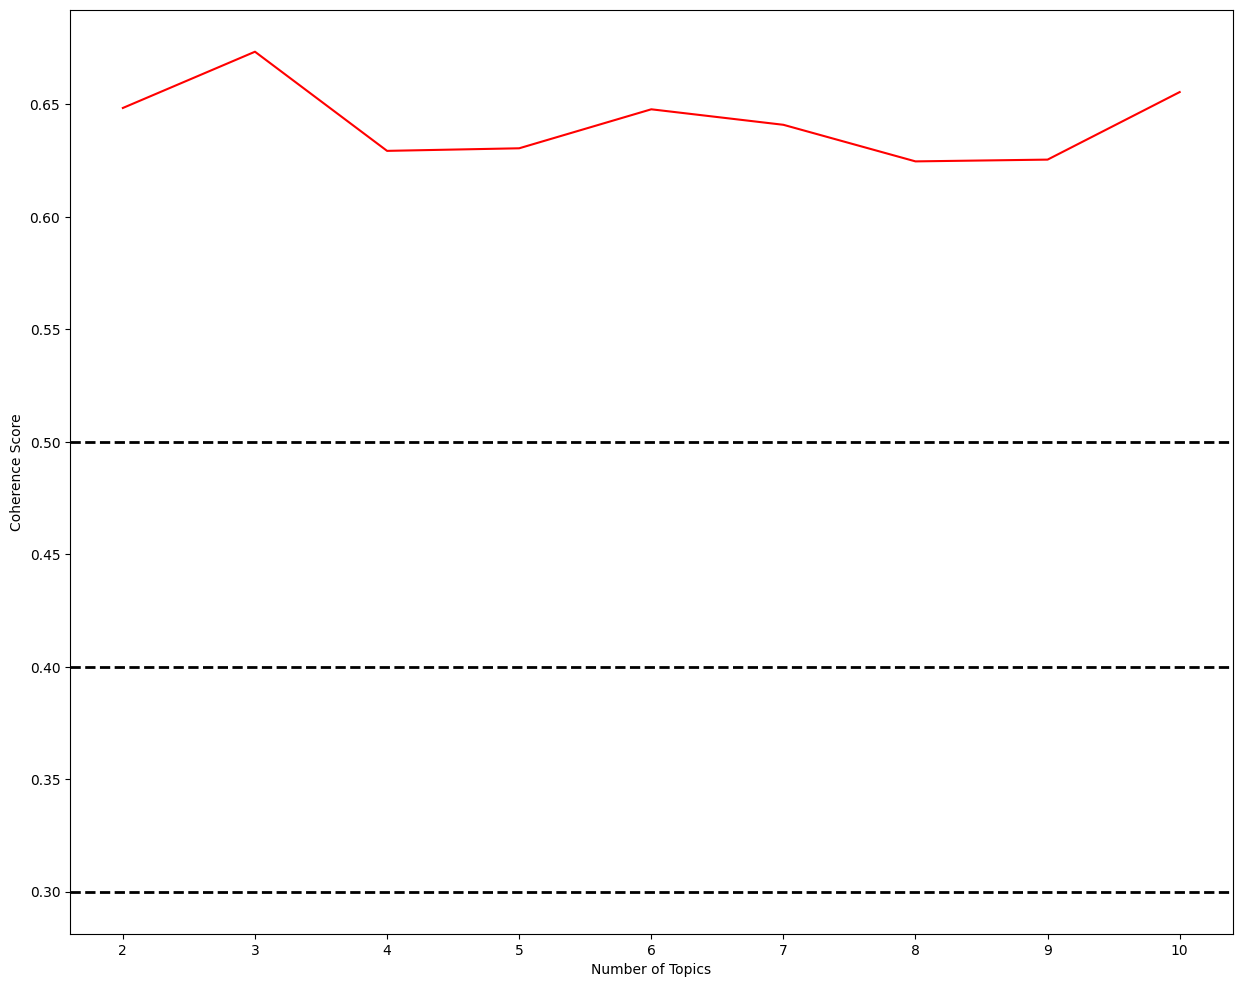

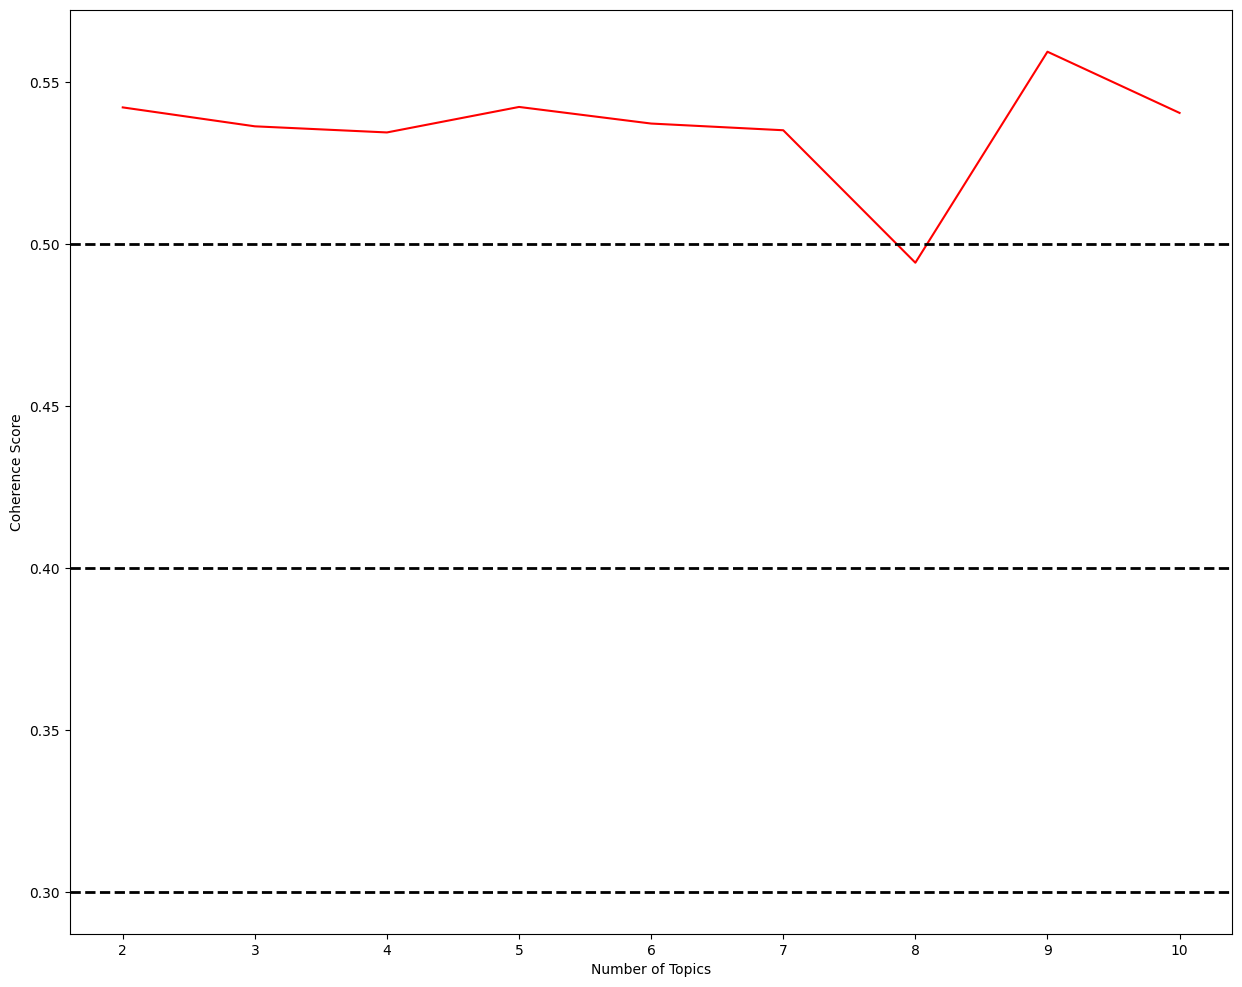


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:44<05:54, 44.25s/it]

Topic #1:
0.199*"service" + 0.188*"bathroom" + 0.170*"shower" + 0.158*"breakfast" + 0.156*"water" + 0.156*"reception" + 0.152*"smell" + 0.151*"dirty" + 0.149*"toilet" + 0.147*"change" + 0.142*"tell" + 0.141*"towel" + 0.139*"sleep" + 0.134*"first" + 0.126*"pay" + 0.121*"request" + 0.116*"wait" + 0.116*"look" + 0.115*"use" + 0.112*"work"

Topic #2:
-0.382*"wait" + 0.331*"bathroom" + -0.310*"tell" + 0.298*"shower" + 0.249*"toilet" + 0.227*"smell" + -0.225*"mind" + -0.201*"service" + -0.198*"breakfast" + 0.165*"dirty" + -0.131*"request" + 0.123*"water" + -0.112*"want" + 0.099*"stain" + -0.094*"another" + -0.089*"reception" + -0.086*"already" + -0.084*"call" + -0.080*"next" + 0.076*"window"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [01:33<05:30, 47.27s/it]

Topic #1:
0.199*"service" + 0.189*"bathroom" + 0.171*"shower" + 0.164*"breakfast" + 0.157*"water" + 0.154*"reception" + 0.152*"smell" + 0.149*"dirty" + 0.149*"toilet" + 0.145*"change" + 0.141*"tell" + 0.139*"towel" + 0.138*"sleep" + 0.133*"first" + 0.128*"pay" + 0.120*"request" + 0.116*"look" + 0.115*"wait" + 0.114*"use" + 0.112*"work"

Topic #2:
-0.386*"wait" + 0.332*"bathroom" + -0.312*"tell" + 0.298*"shower" + 0.247*"toilet" + 0.229*"smell" + -0.229*"mind" + -0.202*"service" + -0.177*"breakfast" + 0.160*"dirty" + -0.135*"request" + 0.124*"water" + -0.114*"want" + 0.098*"stain" + -0.096*"another" + -0.093*"reception" + -0.087*"already" + -0.087*"call" + -0.081*"next" + -0.077*"open"

Topic #3:
0.665*"breakfast" + 0.206*"pay" + -0.202*"change" + -0.189*"dirty" + 0.169*"restaurant" + 0.157*"price" + -0.144*"towel" + -0.127*"reception" + -0.122*"wait" + -0.112*"sleep" + -0.112*"mind" + 0.105*"include" + 0.099*"food" + -0.096*"open" + -0.092*"first" + -0.090*"still" + -0.090*"call" + 0.0

 33%|████████████████████████████                                                        | 3/9 [02:18<04:38, 46.36s/it]

Topic #1:
0.198*"service" + 0.189*"bathroom" + 0.171*"shower" + 0.162*"breakfast" + 0.157*"water" + 0.154*"reception" + 0.153*"smell" + 0.151*"dirty" + 0.150*"toilet" + 0.146*"change" + 0.141*"tell" + 0.141*"towel" + 0.138*"sleep" + 0.133*"first" + 0.128*"pay" + 0.122*"request" + 0.116*"look" + 0.115*"use" + 0.115*"wait" + 0.112*"work"

Topic #2:
-0.342*"wait" + -0.325*"breakfast" + 0.303*"bathroom" + -0.283*"tell" + 0.277*"smell" + 0.274*"shower" + 0.260*"toilet" + -0.242*"service" + -0.199*"mind" + 0.183*"dirty" + 0.121*"water" + -0.112*"pay" + 0.100*"stain" + -0.098*"request" + -0.091*"want" + -0.077*"another" + -0.071*"restaurant" + 0.070*"quite" + -0.069*"manager" + -0.068*"already"

Topic #3:
0.594*"breakfast" + -0.210*"wait" + -0.183*"change" + 0.179*"pay" + -0.160*"towel" + -0.156*"reception" + -0.155*"mind" + 0.145*"price" + 0.144*"restaurant" + -0.136*"request" + -0.135*"tell" + -0.132*"dirty" + 0.131*"shower" + 0.118*"food" + 0.117*"bathroom" + -0.112*"open" + -0.107*"sleep"

 44%|█████████████████████████████████████▎                                              | 4/9 [03:04<03:50, 46.01s/it]

Topic #1:
0.198*"service" + 0.190*"bathroom" + 0.171*"shower" + 0.163*"breakfast" + 0.158*"water" + 0.154*"reception" + 0.153*"smell" + 0.151*"dirty" + 0.150*"toilet" + 0.146*"change" + 0.141*"tell" + 0.141*"towel" + 0.136*"sleep" + 0.133*"first" + 0.127*"pay" + 0.122*"request" + 0.116*"look" + 0.115*"wait" + 0.115*"use" + 0.111*"work"

Topic #2:
-0.351*"breakfast" + 0.316*"bathroom" + -0.314*"wait" + 0.310*"shower" + 0.283*"toilet" + -0.263*"tell" + 0.257*"smell" + -0.232*"service" + -0.178*"mind" + 0.169*"dirty" + 0.138*"water" + -0.114*"pay" + -0.105*"request" + 0.099*"stain" + -0.090*"want" + -0.072*"restaurant" + -0.071*"another" + 0.069*"quite" + -0.068*"already" + -0.066*"manager"

Topic #3:
0.596*"breakfast" + -0.219*"wait" + 0.176*"pay" + -0.176*"change" + -0.161*"mind" + -0.155*"reception" + -0.151*"towel" + 0.145*"price" + 0.143*"restaurant" + -0.141*"tell" + -0.128*"request" + 0.126*"shower" + 0.123*"bathroom" + 0.119*"food" + -0.119*"dirty" + -0.114*"open" + -0.110*"sleep"

 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:52<03:07, 46.84s/it]

Topic #1:
0.198*"service" + 0.190*"bathroom" + 0.172*"shower" + 0.163*"breakfast" + 0.157*"water" + 0.154*"smell" + 0.153*"reception" + 0.152*"dirty" + 0.151*"toilet" + 0.146*"change" + 0.141*"tell" + 0.139*"towel" + 0.137*"sleep" + 0.133*"first" + 0.127*"pay" + 0.121*"request" + 0.116*"look" + 0.116*"wait" + 0.114*"use" + 0.111*"work"

Topic #2:
0.325*"shower" + 0.321*"bathroom" + -0.306*"wait" + -0.304*"breakfast" + 0.293*"toilet" + -0.272*"tell" + 0.262*"smell" + -0.250*"service" + -0.168*"mind" + 0.163*"dirty" + 0.130*"water" + -0.126*"request" + -0.113*"pay" + 0.097*"stain" + -0.097*"want" + -0.083*"reception" + -0.078*"another" + -0.078*"call" + -0.072*"already" + 0.072*"quite"

Topic #3:
0.621*"breakfast" + -0.216*"towel" + -0.183*"change" + 0.162*"pay" + -0.156*"reception" + -0.154*"wait" + 0.152*"price" + 0.148*"restaurant" + -0.145*"request" + -0.138*"dirty" + 0.117*"food" + -0.116*"tell" + 0.116*"shower" + -0.111*"mind" + -0.101*"call" + -0.098*"open" + 0.094*"include" + -0.

 67%|████████████████████████████████████████████████████████                            | 6/9 [04:40<02:21, 47.31s/it]

Topic #1:
0.198*"service" + 0.190*"bathroom" + 0.172*"shower" + 0.162*"breakfast" + 0.156*"water" + 0.154*"reception" + 0.153*"dirty" + 0.153*"smell" + 0.151*"toilet" + 0.146*"change" + 0.141*"tell" + 0.138*"towel" + 0.136*"sleep" + 0.134*"first" + 0.127*"pay" + 0.121*"request" + 0.117*"look" + 0.116*"wait" + 0.114*"use" + 0.111*"work"

Topic #2:
0.323*"shower" + 0.321*"bathroom" + -0.316*"breakfast" + -0.305*"wait" + 0.288*"toilet" + -0.268*"tell" + 0.257*"smell" + -0.250*"service" + 0.170*"dirty" + -0.166*"mind" + 0.128*"water" + -0.128*"request" + -0.114*"pay" + 0.098*"stain" + -0.094*"want" + -0.082*"reception" + -0.078*"another" + -0.077*"call" + 0.072*"quite" + -0.070*"already"

Topic #3:
0.615*"breakfast" + -0.185*"reception" + -0.183*"towel" + -0.171*"dirty" + -0.169*"change" + 0.166*"pay" + -0.154*"wait" + 0.148*"price" + 0.147*"restaurant" + 0.139*"shower" + -0.127*"request" + 0.117*"food" + -0.110*"tell" + -0.105*"mind" + 0.103*"bathroom" + -0.103*"call" + -0.098*"open" + -0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [05:27<01:34, 47.15s/it]

Topic #1:
0.197*"service" + 0.190*"bathroom" + 0.172*"shower" + 0.162*"breakfast" + 0.156*"water" + 0.154*"reception" + 0.154*"dirty" + 0.153*"smell" + 0.151*"toilet" + 0.146*"change" + 0.141*"tell" + 0.139*"towel" + 0.136*"sleep" + 0.133*"first" + 0.127*"pay" + 0.121*"request" + 0.117*"look" + 0.116*"wait" + 0.114*"use" + 0.112*"work"

Topic #2:
0.323*"bathroom" + 0.320*"shower" + -0.314*"breakfast" + -0.303*"wait" + 0.289*"toilet" + -0.266*"tell" + 0.263*"smell" + -0.252*"service" + 0.174*"dirty" + -0.165*"mind" + -0.129*"request" + 0.127*"water" + -0.113*"pay" + 0.100*"stain" + -0.094*"want" + -0.079*"reception" + -0.077*"call" + -0.077*"another" + 0.073*"quite" + -0.070*"already"

Topic #3:
0.629*"breakfast" + -0.182*"towel" + -0.180*"reception" + -0.171*"change" + 0.165*"pay" + -0.163*"dirty" + -0.153*"wait" + 0.149*"restaurant" + 0.143*"price" + 0.138*"shower" + -0.131*"request" + 0.116*"food" + -0.107*"tell" + -0.106*"mind" + 0.103*"bathroom" + -0.102*"call" + -0.097*"first" + -

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [06:16<00:47, 47.56s/it]

Topic #1:
0.198*"service" + 0.190*"bathroom" + 0.172*"shower" + 0.162*"breakfast" + 0.157*"water" + 0.154*"reception" + 0.153*"dirty" + 0.153*"smell" + 0.151*"toilet" + 0.146*"change" + 0.141*"tell" + 0.138*"towel" + 0.137*"sleep" + 0.133*"first" + 0.126*"pay" + 0.121*"request" + 0.117*"look" + 0.116*"wait" + 0.114*"use" + 0.112*"work"

Topic #2:
0.322*"bathroom" + 0.321*"shower" + -0.317*"breakfast" + -0.302*"wait" + 0.291*"toilet" + -0.264*"tell" + 0.263*"smell" + -0.252*"service" + 0.168*"dirty" + -0.164*"mind" + -0.130*"request" + 0.130*"water" + -0.114*"pay" + 0.099*"stain" + -0.091*"want" + -0.081*"reception" + -0.076*"call" + -0.076*"another" + 0.071*"quite" + -0.068*"already"

Topic #3:
0.630*"breakfast" + -0.182*"towel" + -0.172*"reception" + -0.163*"change" + -0.154*"wait" + 0.154*"pay" + -0.150*"dirty" + 0.149*"restaurant" + 0.142*"shower" + 0.138*"price" + -0.132*"request" + 0.117*"food" + 0.113*"bathroom" + -0.113*"tell" + -0.107*"mind" + -0.102*"first" + -0.100*"call" + 0

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:05<00:00, 47.23s/it]


Topic #1:
0.198*"service" + 0.190*"bathroom" + 0.172*"shower" + 0.162*"breakfast" + 0.157*"water" + 0.154*"reception" + 0.153*"dirty" + 0.153*"smell" + 0.151*"toilet" + 0.146*"change" + 0.141*"tell" + 0.138*"towel" + 0.137*"sleep" + 0.134*"first" + 0.126*"pay" + 0.121*"request" + 0.117*"look" + 0.116*"wait" + 0.114*"use" + 0.112*"work"

Topic #2:
0.332*"bathroom" + 0.323*"shower" + -0.308*"breakfast" + -0.302*"wait" + 0.292*"toilet" + -0.264*"tell" + 0.261*"smell" + -0.255*"service" + -0.163*"mind" + 0.163*"dirty" + -0.131*"request" + 0.124*"water" + -0.109*"pay" + 0.097*"stain" + -0.093*"want" + -0.083*"reception" + -0.077*"call" + -0.077*"another" + 0.072*"quite" + 0.067*"mould"

Topic #3:
0.632*"breakfast" + -0.189*"towel" + -0.172*"change" + -0.166*"dirty" + 0.161*"pay" + -0.161*"reception" + 0.152*"price" + 0.147*"restaurant" + 0.144*"shower" + -0.142*"wait" + -0.132*"request" + 0.113*"food" + 0.107*"bathroom" + -0.106*"tell" + -0.101*"first" + -0.100*"mind" + -0.099*"call" + 0.09

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:04<00:39,  4.96s/it]

Topic #1:
0.024*"smell" + 0.016*"dirty" + 0.016*"nothing" + 0.014*"service" + 0.014*"reception" + 0.013*"shower" + 0.013*"bathroom" + 0.011*"old" + 0.010*"price" + 0.010*"pay" + 0.009*"much" + 0.009*"recommend" + 0.009*"want" + 0.009*"water" + 0.008*"feel" + 0.008*"first" + 0.008*"friendly" + 0.008*"toilet" + 0.008*"sleep" + 0.007*"great"

Topic #2:
0.021*"breakfast" + 0.014*"toilet" + 0.013*"work" + 0.013*"really" + 0.012*"service" + 0.012*"bathroom" + 0.012*"water" + 0.010*"sleep" + 0.010*"pool" + 0.010*"nothing" + 0.009*"shower" + 0.009*"food" + 0.009*"expensive" + 0.008*"use" + 0.008*"look" + 0.008*"change" + 0.008*"noisy" + 0.008*"request" + 0.008*"pay" + 0.007*"singapore"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:09<00:33,  4.78s/it]

Topic #1:
0.032*"smell" + 0.019*"dirty" + 0.015*"service" + 0.014*"really" + 0.012*"bathroom" + 0.012*"pool" + 0.011*"sleep" + 0.010*"recommend" + 0.010*"use" + 0.010*"water" + 0.010*"toilet" + 0.010*"price" + 0.009*"towel" + 0.009*"change" + 0.009*"never" + 0.008*"experience" + 0.008*"singapore" + 0.008*"shower" + 0.008*"reception" + 0.008*"expensive"

Topic #2:
0.034*"nothing" + 0.019*"service" + 0.017*"water" + 0.015*"bathroom" + 0.014*"next" + 0.013*"sleep" + 0.013*"want" + 0.011*"shower" + 0.010*"think" + 0.009*"reception" + 0.009*"problem" + 0.009*"noisy" + 0.008*"tell" + 0.008*"enough" + 0.008*"window" + 0.008*"request" + 0.008*"wait" + 0.007*"put" + 0.007*"god" + 0.007*"pay"

Topic #3:
0.032*"breakfast" + 0.019*"work" + 0.018*"toilet" + 0.015*"shower" + 0.013*"food" + 0.012*"old" + 0.012*"pay" + 0.012*"reception" + 0.011*"price" + 0.010*"bathroom" + 0.010*"friendly" + 0.009*"ok" + 0.009*"look" + 0.008*"feel" + 0.008*"space" + 0.008*"dirty" + 0.008*"leave" + 0.007*"worth" + 0.00

 33%|████████████████████████████                                                        | 3/9 [00:14<00:28,  4.73s/it]

Topic #1:
0.035*"nothing" + 0.018*"work" + 0.016*"service" + 0.015*"shower" + 0.013*"water" + 0.012*"reception" + 0.012*"toilet" + 0.010*"want" + 0.010*"find" + 0.009*"big" + 0.009*"towel" + 0.009*"window" + 0.009*"wait" + 0.008*"many" + 0.008*"people" + 0.008*"sleep" + 0.007*"close" + 0.007*"cockroach" + 0.007*"ok" + 0.007*"much"

Topic #2:
0.026*"smell" + 0.016*"pool" + 0.014*"bathroom" + 0.012*"look" + 0.011*"quite" + 0.011*"shower" + 0.011*"expensive" + 0.011*"luggage" + 0.009*"old" + 0.009*"kiss" + 0.009*"however" + 0.009*"space" + 0.008*"thing" + 0.008*"god" + 0.008*"leave" + 0.008*"size" + 0.008*"view" + 0.008*"singapore" + 0.008*"pay" + 0.007*"overall"

Topic #3:
0.032*"breakfast" + 0.020*"service" + 0.014*"really" + 0.013*"request" + 0.013*"price" + 0.013*"next" + 0.012*"water" + 0.011*"change" + 0.011*"friendly" + 0.010*"pay" + 0.010*"noisy" + 0.010*"never" + 0.010*"high" + 0.010*"think" + 0.010*"want" + 0.009*"sleep" + 0.009*"dirty" + 0.009*"little" + 0.009*"call" + 0.008*"f

 44%|█████████████████████████████████████▎                                              | 4/9 [00:18<00:21,  4.34s/it]

Topic #1:
0.033*"bathroom" + 0.025*"work" + 0.020*"toilet" + 0.017*"shower" + 0.016*"water" + 0.014*"smell" + 0.013*"luggage" + 0.012*"service" + 0.012*"quite" + 0.011*"light" + 0.011*"feel" + 0.010*"expect" + 0.010*"seem" + 0.010*"breakfast" + 0.009*"dirty" + 0.009*"everything" + 0.009*"two" + 0.009*"reception" + 0.008*"price" + 0.008*"every"

Topic #2:
0.029*"breakfast" + 0.021*"work" + 0.016*"want" + 0.016*"sleep" + 0.014*"look" + 0.011*"close" + 0.009*"enough" + 0.009*"great" + 0.009*"really" + 0.009*"expensive" + 0.009*"smell" + 0.009*"bathroom" + 0.009*"tiny" + 0.009*"friendly" + 0.009*"view" + 0.008*"big" + 0.008*"reception" + 0.008*"dirty" + 0.008*"city" + 0.008*"thing"

Topic #3:
0.047*"nothing" + 0.019*"water" + 0.019*"price" + 0.016*"pool" + 0.016*"shower" + 0.014*"recommend" + 0.013*"never" + 0.012*"toilet" + 0.011*"really" + 0.010*"cold" + 0.010*"pay" + 0.010*"first" + 0.010*"old" + 0.010*"bathroom" + 0.010*"think" + 0.009*"everything" + 0.009*"change" + 0.009*"sleep" + 0.

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:21<00:16,  4.19s/it]

Topic #1:
0.023*"pool" + 0.018*"star" + 0.017*"sleep" + 0.014*"next" + 0.014*"wait" + 0.014*"reception" + 0.014*"quite" + 0.014*"noise" + 0.013*"sound" + 0.013*"find" + 0.011*"hear" + 0.011*"noisy" + 0.011*"toilet" + 0.010*"people" + 0.010*"open" + 0.010*"thing" + 0.009*"pay" + 0.009*"none" + 0.009*"old" + 0.009*"kiss"

Topic #2:
0.030*"service" + 0.016*"request" + 0.016*"toilet" + 0.016*"nothing" + 0.014*"view" + 0.013*"however" + 0.012*"price" + 0.011*"breakfast" + 0.011*"close" + 0.011*"recommend" + 0.010*"window" + 0.010*"city" + 0.010*"singapore" + 0.010*"pay" + 0.010*"restaurant" + 0.009*"poor" + 0.009*"reception" + 0.009*"big" + 0.009*"expect" + 0.009*"shower"

Topic #3:
0.073*"nothing" + 0.023*"really" + 0.019*"shower" + 0.016*"leave" + 0.014*"provide" + 0.013*"size" + 0.013*"god" + 0.011*"facility" + 0.011*"front_desk" + 0.011*"drink" + 0.011*"available" + 0.010*"change" + 0.010*"service" + 0.010*"cramp" + 0.010*"noisy" + 0.009*"cold" + 0.009*"space" + 0.009*"towel" + 0.009*"w

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:25<00:12,  4.03s/it]

Topic #1:
0.024*"old" + 0.018*"dirty" + 0.018*"bathroom" + 0.014*"two" + 0.014*"god" + 0.013*"sleep" + 0.013*"toilet" + 0.012*"look" + 0.012*"rude" + 0.011*"cold" + 0.011*"want" + 0.011*"use" + 0.010*"lack" + 0.010*"towel" + 0.010*"request" + 0.010*"change" + 0.009*"leave" + 0.009*"recommend" + 0.009*"lady" + 0.009*"mould"

Topic #2:
0.039*"breakfast" + 0.032*"work" + 0.021*"food" + 0.020*"reception" + 0.018*"experience" + 0.016*"look" + 0.014*"great" + 0.013*"want" + 0.013*"service" + 0.012*"shower" + 0.012*"photo" + 0.010*"ok" + 0.010*"terrible" + 0.009*"serve" + 0.009*"request" + 0.009*"really" + 0.009*"recommend" + 0.008*"properly" + 0.008*"totally" + 0.008*"limit"

Topic #3:
0.016*"pool" + 0.015*"towel" + 0.014*"dirty" + 0.014*"really" + 0.014*"use" + 0.013*"know" + 0.013*"nothing" + 0.012*"enough" + 0.010*"none" + 0.010*"wife" + 0.010*"bar" + 0.010*"see" + 0.010*"change" + 0.010*"want" + 0.009*"never" + 0.009*"another" + 0.008*"walk" + 0.008*"look" + 0.008*"far" + 0.008*"smell"



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:29<00:07,  3.99s/it]

Topic #1:
0.029*"reception" + 0.021*"work" + 0.019*"shower" + 0.017*"request" + 0.014*"next" + 0.014*"smell" + 0.014*"water" + 0.012*"little" + 0.011*"first" + 0.010*"price" + 0.010*"god" + 0.010*"use" + 0.010*"know" + 0.010*"always" + 0.010*"sleep" + 0.009*"dirty" + 0.009*"high" + 0.009*"may" + 0.009*"another" + 0.009*"open"

Topic #2:
0.018*"station" + 0.017*"rude" + 0.015*"cleanliness" + 0.015*"service" + 0.013*"leave" + 0.012*"reception" + 0.011*"never" + 0.011*"many" + 0.010*"walk" + 0.010*"want" + 0.010*"space" + 0.010*"ok" + 0.010*"help" + 0.010*"pretty" + 0.010*"close" + 0.010*"wait" + 0.010*"deposit" + 0.010*"feel" + 0.009*"dirty" + 0.009*"toilet"

Topic #3:
0.030*"service" + 0.022*"bathroom" + 0.017*"water" + 0.017*"star" + 0.015*"towel" + 0.013*"request" + 0.013*"change" + 0.013*"first" + 0.012*"pay" + 0.012*"use" + 0.012*"provide" + 0.011*"dirty" + 0.011*"reception" + 0.010*"never" + 0.010*"find" + 0.010*"deposit" + 0.010*"call" + 0.010*"shower" + 0.010*"still" + 0.009*"poo

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:33<00:03,  3.93s/it]

Topic #1:
0.029*"look" + 0.021*"always" + 0.019*"size" + 0.017*"smell" + 0.016*"never" + 0.014*"water" + 0.014*"deposit" + 0.014*"service" + 0.013*"lobby" + 0.013*"ac" + 0.012*"luggage" + 0.012*"restaurant" + 0.012*"space" + 0.011*"shower" + 0.010*"inside" + 0.010*"dirty" + 0.010*"use" + 0.010*"family" + 0.010*"walk" + 0.010*"air"

Topic #2:
0.031*"smell" + 0.017*"want" + 0.017*"toilet" + 0.015*"dirty" + 0.015*"sleep" + 0.014*"another" + 0.014*"shower" + 0.012*"reception" + 0.011*"really" + 0.011*"feel" + 0.011*"change" + 0.010*"wait" + 0.010*"pay" + 0.010*"first" + 0.009*"know" + 0.009*"charge" + 0.009*"early" + 0.009*"thing" + 0.008*"sheet" + 0.008*"due"

Topic #3:
0.023*"water" + 0.023*"friendly" + 0.022*"work" + 0.021*"old" + 0.015*"toilet" + 0.014*"look" + 0.014*"light" + 0.013*"food" + 0.013*"enough" + 0.013*"provide" + 0.012*"change" + 0.012*"people" + 0.011*"build" + 0.011*"noisy" + 0.011*"big" + 0.011*"stain" + 0.011*"shower" + 0.010*"dirty" + 0.010*"next" + 0.010*"star"

Topi

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  4.14s/it]

Topic #1:
0.040*"work" + 0.037*"service" + 0.021*"price" + 0.021*"breakfast" + 0.018*"reception" + 0.015*"enough" + 0.015*"toilet" + 0.014*"shower" + 0.012*"wife" + 0.011*"recommend" + 0.011*"smell" + 0.010*"may" + 0.010*"lobby" + 0.010*"pay" + 0.010*"rude" + 0.010*"lack" + 0.009*"little" + 0.009*"call" + 0.009*"request" + 0.009*"use"

Topic #2:
0.022*"breakfast" + 0.017*"toilet" + 0.017*"poor" + 0.015*"luggage" + 0.014*"shower" + 0.014*"big" + 0.013*"service" + 0.013*"another" + 0.012*"smell" + 0.011*"put" + 0.011*"pay" + 0.010*"ok" + 0.010*"really" + 0.010*"lot" + 0.010*"singapore" + 0.009*"expensive" + 0.009*"size" + 0.009*"money" + 0.008*"water" + 0.008*"city"

Topic #3:
0.020*"find" + 0.019*"water" + 0.018*"never" + 0.017*"leave" + 0.016*"look" + 0.016*"food" + 0.014*"toilet" + 0.014*"work" + 0.013*"luggage" + 0.013*"restaurant" + 0.013*"facility" + 0.013*"smell" + 0.012*"want" + 0.012*"close" + 0.012*"cold" + 0.012*"breakfast" + 0.011*"reception" + 0.011*"many" + 0.011*"sleep" + 

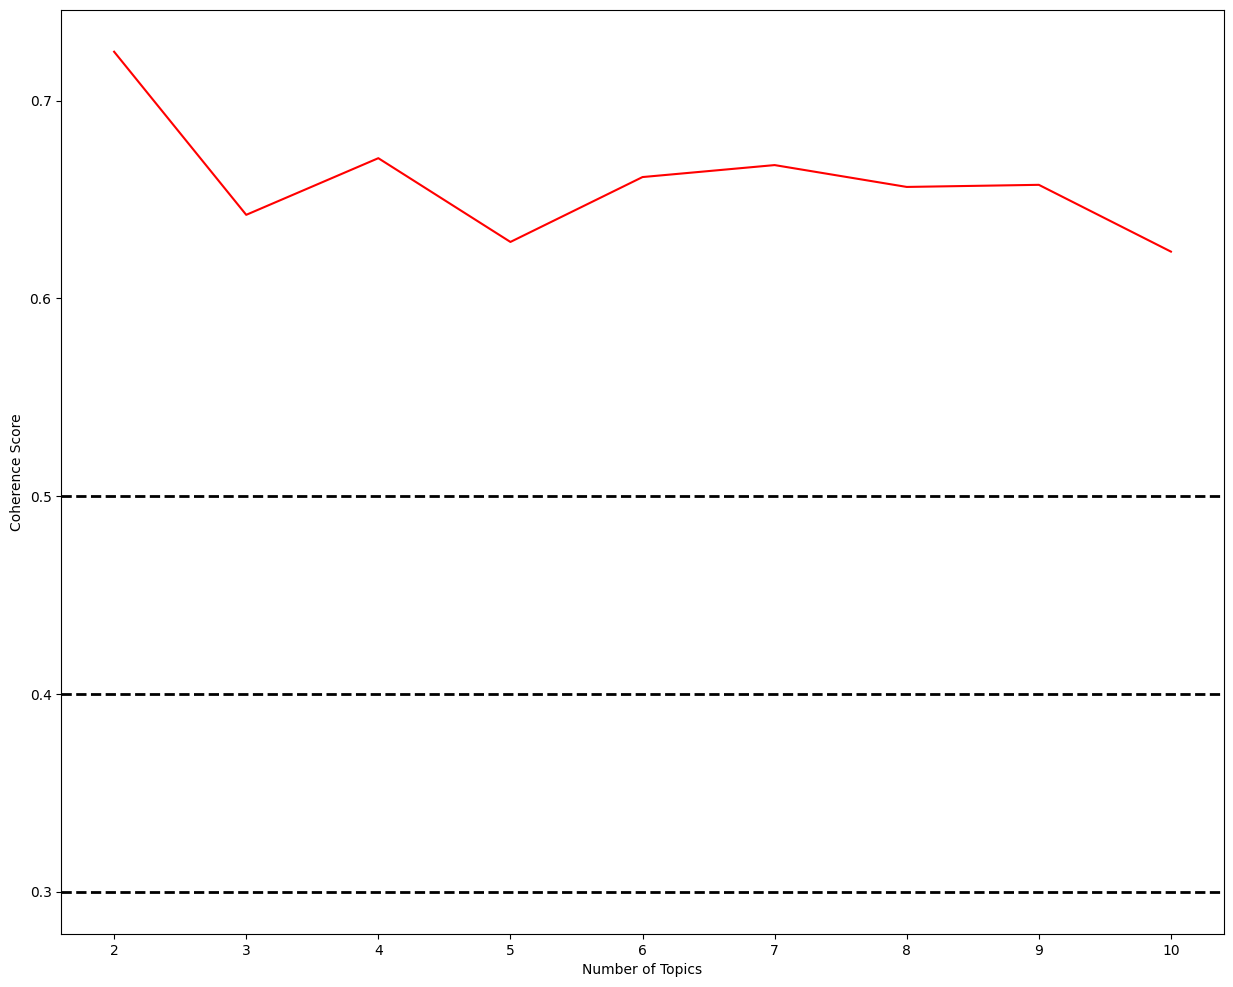

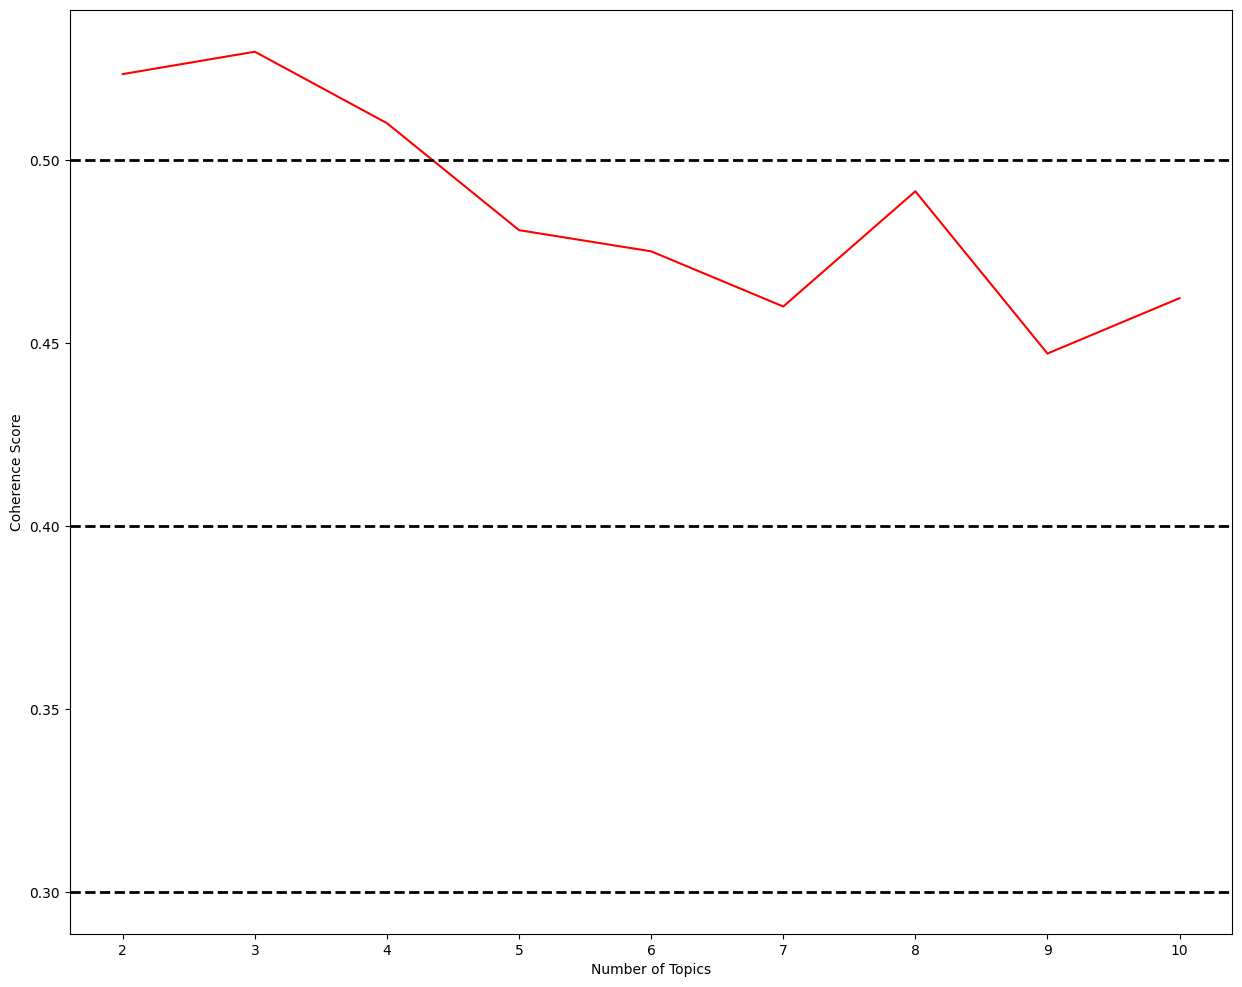

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v3"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.648451,df_pos
1,LSI,3,0.673458,df_pos
2,LSI,4,0.629380,df_pos
3,LSI,5,0.630526,df_pos
4,LSI,6,0.647862,df_pos
5,LSI,7,0.640970,df_pos
6,LSI,8,0.624703,df_pos
7,LSI,9,0.625490,df_pos
8,LSI,10,0.655525,df_pos
0,LDA,2,0.542245,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.724670,df_neg
1,LSI,3,0.673458,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 2

Topic 1: service, bathroom, shower, breakfast, water, reception, smell, dirty, toilet, change

Topic 2: wait, bathroom, tell, shower, toilet, smell, mind, service, breakfast, dirty

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 3

Topic 1: great, friendly, station, breakfast, helpful, overall, really, singapore, close, food

Topic 2: great, station, shower, quite, toilet, bathroom, towel, bus, water, really

Topic 3: station, breakfast, shower, bus, reception, food, close, toilet, restaurant, bathroom

----------



In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-27 01:15:38.128999
Text processing spent 0:35:21.688814
